In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, svm
import statsmodels.api as sm
import numpy as np
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss
import ipywidgets as widgets
from scipy.special import expit

In [2]:
%matplotlib inline

In [37]:
df = pd.read_csv("SDSS-DR14.csv")
df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


## Descripción de los datos
- Datos de posicionamiento
    - objid: Object ID
    - ra: Right Ascension
    - dec: Declination

- Magnitudes de longitud de onda {u,g,r,i,z}
    - u: Ultraviolet
    - g: Green
    - r: Red
    - i: Infrared - 7600 Â
    - z: Infrared - 9100 Â

- Observación Óptica {redshift,plate,mjd,fiberid}
    - redshift: Final redshift, efecto de "correr al rojo" producido por el efecto Doppler
    - plate: SDSS plug plate used
    - mjd: Modified Julian Date
    - fiberid: Fiber number

Las siguientes características no se usaran ya que no describen alguna propiedad de los cuerpos celestes observados

- objid
- ra
- dec
- run
- rerun
- camcol
- field
- specobjid
- plate
- mjd
- fiberid

In [39]:
#Drop unused columns
df.drop(columns = ['objid','ra','dec','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'], inplace=True)

### Exploración de los datos

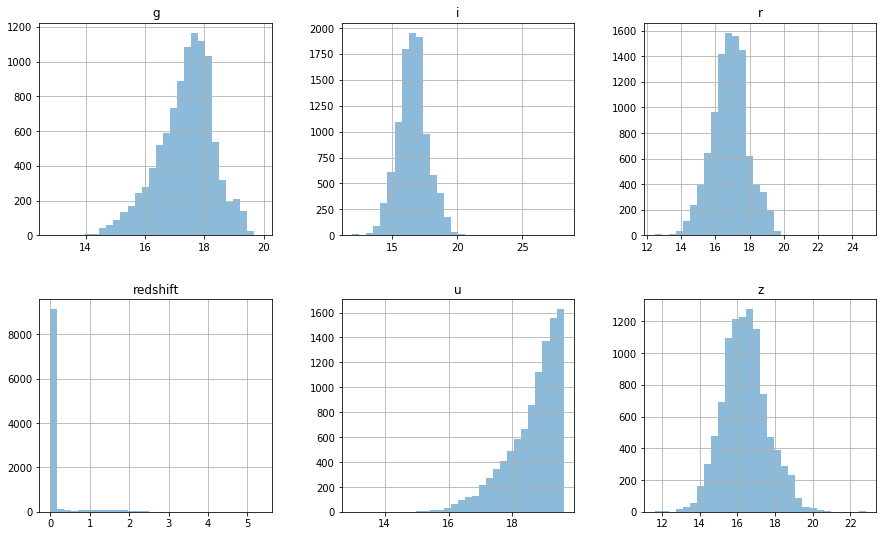

In [63]:
#Distribution Analysis
fig,ax = plt.subplots(nrows=2,ncols=3, figsize = (15,9))
df.hist(bins = 30, alpha = 0.5, ax=ax)
plt.show()

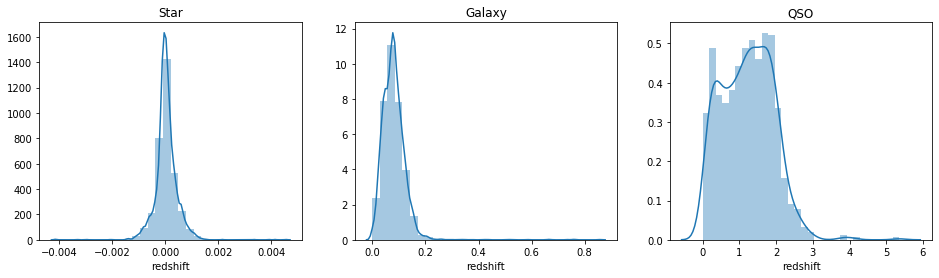

In [65]:
#Redshift distribution by class
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))

ax = sb.distplot(df[df['class']=='STAR'].redshift, bins = 30, ax = axes[0])
ax.set_title('Star')
ax = sb.distplot(df[df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1])
ax.set_title('Galaxy')
ax = sb.distplot(df[df['class']=='QSO'].redshift, bins = 30, ax = axes[2])
ax = ax.set_title('QSO')
plt.show()

#### Separacion de los datos

In [6]:
Y = df['class']

In [7]:
X = df.drop(columns = ['class'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .4, random_state=45)

In [66]:
print('Total train samples by class \n', y_train.value_counts())
print('Training Data Ratios: \n', y_train.value_counts()/y_train.value_counts().min())

Total train samples by class 
 GALAXY    2969
STAR      2499
QSO        532
Name: class, dtype: int64
Training Data Ratios: 
 GALAXY    5.580827
STAR      4.697368
QSO       1.000000
Name: class, dtype: float64


Matriz de correlación


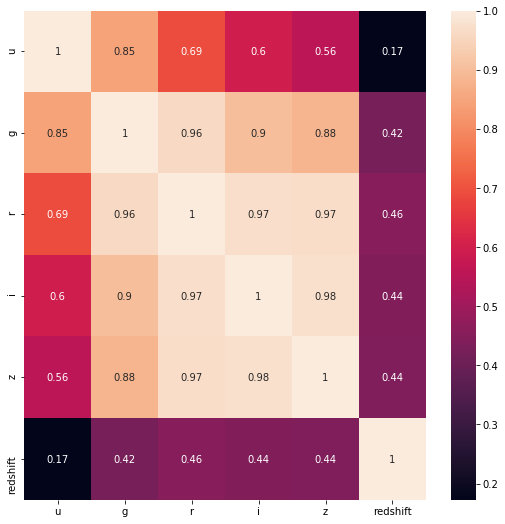

In [43]:
print("Matriz de correlación")
f,ax = plt.subplots(figsize=(9, 9))
sb.heatmap(X_train.corr(), annot = True, ax=ax)
plt.show()

### Es necesario balancear el dataset de entrenamiento
Ante la posibilidad de que el modelo sea sobreentrenado se usara <i>Undersampling</i> como balanceador

In [11]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=5, n_jobs = -1)
# transform the dataset
undersampled_trainX, undersampled_trainY = undersample.fit_resample(X_train, y_train)
undersampled_train = pd.concat([pd.DataFrame(undersampled_trainY), pd.DataFrame(undersampled_trainX)], axis=1)

In [12]:
undersampled_train.groupby('class').count()

,u,g,r,i,z,redshift
class,,,,,,
GALAXY,532,532,532,532,532,532
QSO,532,532,532,532,532,532
STAR,532,532,532,532,532,532


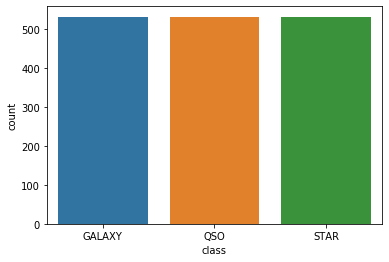

In [13]:
sb.countplot(x = 'class', data = undersampled_train)
plt.show()

Matriz de correlación despues del balance


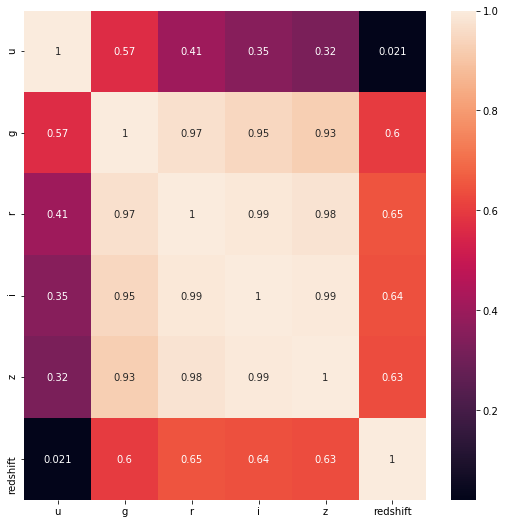

In [14]:
print("Matriz de correlación despues del balance")
f,ax = plt.subplots(figsize=(9, 9))
sb.heatmap(undersampled_trainX.corr(), annot=True, ax=ax)
plt.show()

# Aprendizaje de modelos

### Logistic Regression

In [15]:
#Aprendizaje
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(undersampled_trainX, undersampled_trainY)

LogisticRegression(max_iter=10000)

In [16]:
#Predicciones
y_pred = logreg.predict(X_test)

In [17]:
#Evaluación del rendimiento del clasificador
logreg_matrix = confusion_matrix(y_test, y_pred)

In [18]:
logreg_report = classification_report(y_test, y_pred)

### Decision tree

In [19]:
from sklearn import tree
#Entrenamiento
dtree = tree.DecisionTreeClassifier()
dtree.fit(undersampled_trainX,undersampled_trainY)

DecisionTreeClassifier()

In [20]:
#Predicciones
y_pred = dtree.predict(X_test)
#Evaluación del rendimiento del clasificador
#from sklearn.metrics import confusion_matrix
tree_matrix = confusion_matrix(y_test, y_pred)
#Print de la matriz de confusión
tree_report = classification_report(y_test, y_pred)

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=15)
#Profiling
forest.fit(undersampled_trainX,undersampled_trainY) 

RandomForestClassifier(n_estimators=15)

In [22]:
#Predicciones
y_pred = forest.predict(X_test)
#Evaluación del rendimiento del clasificador
forest_matrix = confusion_matrix(y_test, y_pred)
#Print de la matriz de confusión
forest_report = classification_report(y_test, y_pred)

# Model Evaluation

### Logistic Regression

In [23]:
print("Logistic Regression Report: \n" + logreg_report)

Logistic Regression Report: 
              precision    recall  f1-score   support

      GALAXY       0.97      0.83      0.89      2029
         QSO       0.95      0.96      0.96       318
        STAR       0.83      0.97      0.89      1653

    accuracy                           0.90      4000
   macro avg       0.92      0.92      0.91      4000
weighted avg       0.91      0.90      0.90      4000



Como se puede apreciar en el reporte, este modelo se ajusta bien a los datos de entrenamiento lo que resulta en una muy buena predicción para la clasificación de clases de cuerpos celestes con un 90% de exactitud.

In [24]:
print('Coeficientes de características')
cols = X_train.columns
for i in logreg.classes_:
    row = logreg.coef_[np.where(logreg.classes_ == i)[0][0]]
    maxi = np.max(row)
    print(i,maxi,cols[np.where(row == maxi)[0][0]])

Coeficientes de características
GALAXY 2.551417430906273 r
QSO 4.537550982823424 redshift
STAR 4.353255532480775 z


LogisticRegression calcula distintos coeficientes para cada caracteristica para cada clase. La caracteristica más importante (con mas peso) para la clase GALAXY es <i>r</i>, para QSO es <i>redshift</i> y para STAR es <i>z</i>

### Desicion Tree

In [25]:
print("Desicion Tree Report: \n" + tree_report)

Desicion Tree Report: 
              precision    recall  f1-score   support

      GALAXY       0.99      0.63      0.77      2029
         QSO       0.29      0.96      0.45       318
        STAR       0.98      1.00      0.99      1653

    accuracy                           0.81      4000
   macro avg       0.76      0.86      0.74      4000
weighted avg       0.93      0.81      0.83      4000



Después de balancear los datos, la precisión para clasificar un Quasar y el recall para clasificar una Galaxia son demasiado bajos como para considerar que sea un buen modelo de clasificación para nuestro dataset

In [26]:
print('Coeficiente de Características\n')
for x in range(dtree.feature_importances_.size):
    print(X_train.columns[x],dtree.feature_importances_[x])

Coeficiente de Características

u 0.025585749184313777
g 0.016304250661112733
r 0.007269384516659401
i 0.00651884200187524
z 0.003531623151051046
redshift 0.9407901504849878


La característica más importante para este modelo es <i>redshift</i> con un peso de 0.94

### Random Forest

In [33]:
print("Random Forest Report: \n" + forest_report)

Random Forest Report: 
              precision    recall  f1-score   support

      GALAXY       1.00      0.58      0.74      2029
         QSO       0.28      0.99      0.43       318
        STAR       0.98      1.00      0.99      1653

    accuracy                           0.79      4000
   macro avg       0.75      0.86      0.72      4000
weighted avg       0.93      0.79      0.82      4000



Para clasificar si un cuerpo celeste es una estrella, nuestro modelo de Random Forest es perfecto, sin embargo, para las otras clases obtiene un rendimiento insuficiente como lo es en la precision de la clase QSO o en el recall de GALAXY, se puede apreciar en el bajo f1-score obtenido.

In [34]:
print('Coeficiente de características')
for x in range(forest.feature_importances_.size):
    print(X_train.columns[x],forest.feature_importances_[x])

Coeficiente de características
u 0.048852360590074514
g 0.09341769948130144
r 0.1454121646434636
i 0.08045760088176825
z 0.12883094038855866
redshift 0.5030292340148336


La característica más importante para éste modelo es <i>redshift</i>

In [36]:
print("Logistic Regression Report: \n" + logreg_report)
print("Desicion Tree Report: \n" + tree_report)
print("Random Forest Report: \n" + forest_report)

Logistic Regression Report: 
              precision    recall  f1-score   support

      GALAXY       0.97      0.83      0.89      2029
         QSO       0.95      0.96      0.96       318
        STAR       0.83      0.97      0.89      1653

    accuracy                           0.90      4000
   macro avg       0.92      0.92      0.91      4000
weighted avg       0.91      0.90      0.90      4000

Desicion Tree Report: 
              precision    recall  f1-score   support

      GALAXY       0.99      0.63      0.77      2029
         QSO       0.29      0.96      0.45       318
        STAR       0.98      1.00      0.99      1653

    accuracy                           0.81      4000
   macro avg       0.76      0.86      0.74      4000
weighted avg       0.93      0.81      0.83      4000

Random Forest Report: 
              precision    recall  f1-score   support

      GALAXY       1.00      0.58      0.74      2029
         QSO       0.28      0.99      0.43       318
